# Data Analysis
### Predictive modelling of stroke occurences

NB: This is the pipeline used for the results that are saved in the models folder. 
However, this notebook has been run since and therefore the current results are different from the actual results reported. 
This is therefore only the pipeline that was used. To replicate the result, find them in the interpret_results notebook. 

Import libraries

In [1]:
import pandas as pd
from utils import DataLoader, Performance, InterpretModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix

c:\Users\Bruger\anaconda3\envs\datascience\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Fit models
- ANN
- Random Forest
- XGBoost

### ANN
I will define the model. Then preprocess the data and split it. 
Then I will loop through different undersampling permutations to and average the accuracy of the resulting models. 

In [2]:
# load and preprocess data 

data_loader = DataLoader("data/healthcare-dataset-stroke-data.csv")
data_loader.load_dataset()

data_loader.preprocess_data()
# Split the data for testing and training for ANN 
X_train, X_test, X_val, y_train, y_test, y_val = data_loader.get_data_split(ANN = True)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(3065, 20)
(1022, 20)
(1022, 20)


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.random.set_seed(2)
from sklearn.preprocessing import StandardScaler

#### Define model

In [4]:
#ANN MODEL
model = Sequential()

model.add(Dense(units = 14, activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units = 7, activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units = 3, activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy') # metrics=[tf.keras.metrics.FalsePositives()]

#### Define early stopping callback

In [82]:
#stops when validation loss is not dropping for 3 epochs
#early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 1)
# Rule of thumb, patience is 10% of the number of epochs 
# We need to save the model 
callbacks = [EarlyStopping(monitor='val_loss', patience=12),
             ModelCheckpoint(filepath='models/best_model.h5', monitor='val_loss', save_best_only=True)]

#### Fit model on permutations

In [6]:
performance = Performance()
performance_list = []
from keras.models import load_model

#Fitting model 10 times
for p in range(100):
    # Undersample the train data 
    X_train_under, y_train_under = data_loader.undersample(X_train, y_train)
    print("After undersampling:", X_train.shape)
    
    #Scale and Fit the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_under)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)

    model.fit(X_train_scaled, y_train_under, 
            epochs = 150,
            validation_data=(X_val_scaled, y_val),
            verbose = 1, 
            callbacks=callbacks, batch_size=30)

    # load best model
    saved_model = load_model('models/best_model.h5')

    prediction_values = model.predict(X_test_scaled)
    # Convert into classes 
    prediction = []
    for i in prediction_values:
        prediction.append(np.where(i > 0.5, 1,0)[0])  
          
    performance_list.append(performance.evaluate(test_labels = y_test, predictions = prediction))
    print(performance.evaluate(test_labels = y_test, predictions = prediction))


After undersampling: (3065, 20)
Epoch 1/150
11/11 [==============================] - 2s 54ms/step - loss: 0.6880 - accuracy: 0.4903 - val_loss: 0.6478 - val_accuracy: 0.9423
Epoch 2/150
11/11 [==============================] - 0s 19ms/step - loss: 0.6892 - accuracy: 0.5032 - val_loss: 0.6469 - val_accuracy: 0.4795
Epoch 3/150
11/11 [==============================] - 0s 23ms/step - loss: 0.6869 - accuracy: 0.5487 - val_loss: 0.6440 - val_accuracy: 0.4883
Epoch 4/150
11/11 [==============================] - 0s 18ms/step - loss: 0.6768 - accuracy: 0.5747 - val_loss: 0.6402 - val_accuracy: 0.4883
Epoch 5/150
11/11 [==============================] - 0s 17ms/step - loss: 0.6813 - accuracy: 0.6006 - val_loss: 0.6358 - val_accuracy: 0.5078
Epoch 6/150
11/11 [==============================] - 0s 16ms/step - loss: 0.6834 - accuracy: 0.5487 - val_loss: 0.6314 - val_accuracy: 0.5254
Epoch 7/150
11/11 [==============================] - 0s 15ms/step - loss: 0.6674 - accuracy: 0.6266 - val_loss: 0.62

In [7]:
# we check the differences in performance
# we find that the differences are not too big +-0.04
print("Difference from max to min accuracy:", np.round(max(performance_list) - min(performance_list), 2))
print("Mean accuracy:", np.round(np.mean(performance_list), 2))

Difference from max to min accuracy: 0.09
Mean accuracy: 0.72


Since the difference in accuracy only differs with 0.13 from minimum to maximum, I continue with just one sample. 

### Fit model

In [76]:
# Undersample the train data 
X_train, y_train = data_loader.undersample(X_train, y_train)
print("After undersampling:", X_train.shape)
#Scale and Fit the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


After undersampling: (396, 20)


In [83]:
#Fitting model
model.fit(X_train_scaled, y_train, 
          epochs = 150,
         validation_data=(X_val_scaled, y_val),
         verbose = 1, 
         callbacks=callbacks, batch_size=30)

Epoch 1/150
14/14 [==============================] - 0s 18ms/step - loss: 0.3756 - accuracy: 0.8460 - val_loss: 0.4835 - val_accuracy: 0.7241
Epoch 2/150
14/14 [==============================] - 0s 13ms/step - loss: 0.3972 - accuracy: 0.8434 - val_loss: 0.4817 - val_accuracy: 0.7241
Epoch 3/150
14/14 [==============================] - 0s 12ms/step - loss: 0.3894 - accuracy: 0.8561 - val_loss: 0.4808 - val_accuracy: 0.7241
Epoch 4/150
14/14 [==============================] - 0s 14ms/step - loss: 0.3331 - accuracy: 0.8662 - val_loss: 0.4802 - val_accuracy: 0.7192
Epoch 5/150
14/14 [==============================] - 0s 13ms/step - loss: 0.3544 - accuracy: 0.8662 - val_loss: 0.4684 - val_accuracy: 0.7270
Epoch 6/150
14/14 [==============================] - 0s 12ms/step - loss: 0.3346 - accuracy: 0.8763 - val_loss: 0.4645 - val_accuracy: 0.7280
Epoch 7/150
14/14 [==============================] - 0s 8ms/step - loss: 0.3495 - accuracy: 0.8611 - val_loss: 0.4712 - val_accuracy: 0.7250
Epoch 8

Text(0.5, 1.0, 'Training loss and accuracies')

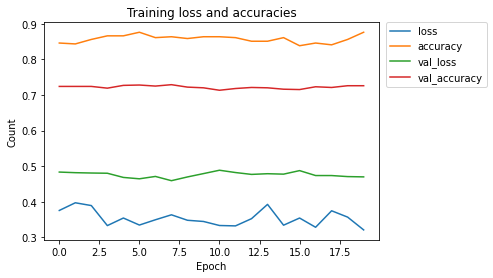

In [84]:
# Visualize training
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Epoch")
plt.ylabel("Count")
plt.title("Training loss and accuracies")

##### Performance of ANN model

In [85]:
# First we load the best model
from keras.models import load_model
saved_model = load_model('models/best_model.h5')

#Predictions
prediction_values = saved_model.predict(X_test_scaled)
# Convert into classes 
prediction_best = []
for i in prediction_values:
    prediction_best.append(np.where(i > 0.5, 1,0)[0])

performance = Performance()
saved_model_performance = performance.evaluate(test_labels = y_test, predictions = prediction_best)

32/32 [==============================] - 0s 1ms/step
Model Performance
Accuracy = 70.74%.
Recall strokes only = 72.55%.


We also check the last model since we were optimizing for accuracy, the recall of strokes might be better here

In [89]:
#Predictions
prediction_values = model.predict(X_test_scaled)
# Convert into classes 
prediction = []
for i in prediction_values:
    prediction.append(np.where(i > 0.5, 1,0)[0])

model_performance = performance.evaluate(test_labels = y_test, predictions = prediction)

32/32 [==============================] - 0s 2ms/step
Model Performance
Accuracy = 70.45%.
Recall strokes only = 70.59%.


We choose the best model for classification report

We make classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.71      0.82       971
           1       0.11      0.73      0.20        51

    accuracy                           0.71      1022
   macro avg       0.55      0.72      0.51      1022
weighted avg       0.94      0.71      0.79      1022



<AxesSubplot:>

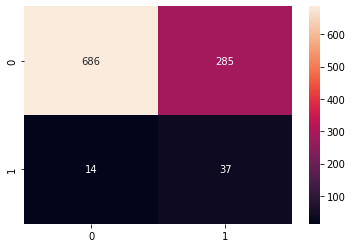

In [88]:
print(classification_report(y_test,prediction_best))

cf = confusion_matrix(y_test,prediction_best)

import seaborn as sns
sns.heatmap(cf, annot=True, fmt='g')

Visualize with a Heatmap

# Next two models

Now we split again to not have the val data for these models

In [14]:
X_train, X_test, y_train, y_test = data_loader.get_data_split(ANN = False)
print(X_train.shape)
print(X_test.shape)

# Undersample the train data 
X_train, y_train = data_loader.undersample(X_train, y_train)
print("After undersampling:", X_train.shape)

(4087, 20)
(1022, 20)
After undersampling: (396, 20)


### XGBoost


In [15]:
from xgboost import XGBClassifier
XGB = XGBClassifier(eval_metric= 'rmsle')
XGB.fit(X_train, y_train) # Fit model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='rmsle', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

              precision    recall  f1-score   support

           0       0.98      0.70      0.82       971
           1       0.12      0.76      0.20        51

    accuracy                           0.70      1022
   macro avg       0.55      0.73      0.51      1022
weighted avg       0.94      0.70      0.79      1022


Model Performance
Accuracy = 70.25%.
Recall strokes only = 76.47%.


<AxesSubplot:>

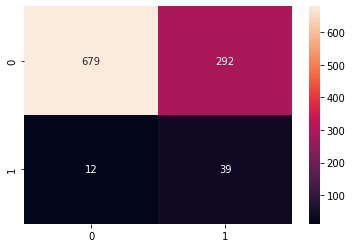

In [16]:
y_pred = XGB.predict(X_test) # Make predictions
print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)
XGB_performance = performance.evaluate(test_labels = y_test, predictions = y_pred)
sns.heatmap(cf, annot = True, fmt='g')

#### Random search

In [17]:
from sklearn.model_selection import RandomizedSearchCV
params = { 'max_depth': [0, 3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
clf = RandomizedSearchCV(estimator=XGB,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.6}
Lowest RMSE:  0.48986564936764015


              precision    recall  f1-score   support

           0       0.98      0.73      0.84       971
           1       0.13      0.75      0.22        51

    accuracy                           0.73      1022
   macro avg       0.56      0.74      0.53      1022
weighted avg       0.94      0.73      0.81      1022


Model Performance
Accuracy = 73.39%.
Recall strokes only = 74.51%.


<AxesSubplot:>

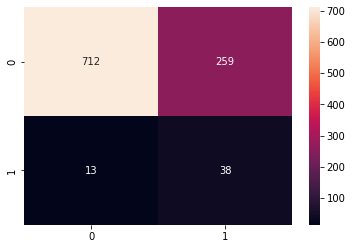

In [18]:
best_XGB = clf.best_estimator_
y_pred = best_XGB.predict(X_test) # Make predictions
print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)
XGB_performance = performance.evaluate(test_labels = y_test, predictions = y_pred)
sns.heatmap(cf, annot = True, fmt='g')

### Grid search

In [19]:
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [0,10,20],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [300, 500, 700],
           'colsample_bytree': [0.5, 0.9], 
           'colsample_bylevel': [0.5, 0.8]}

clf = GridSearchCV(estimator=XGB, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300}
Lowest RMSE:  0.4660974527317629


              precision    recall  f1-score   support

           0       0.98      0.70      0.82       971
           1       0.12      0.78      0.21        51

    accuracy                           0.70      1022
   macro avg       0.55      0.74      0.51      1022
weighted avg       0.94      0.70      0.79      1022


Model Performance
Accuracy = 70.16%.
Recall strokes only = 78.43%.


<AxesSubplot:>

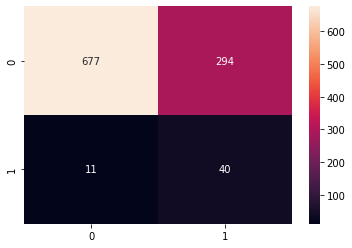

In [20]:
best_XGB = clf.best_estimator_
y_pred = best_XGB.predict(X_test) # Make predictions
print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)
XGB_performance = performance.evaluate(test_labels = y_test, predictions = y_pred)
sns.heatmap(cf, annot = True, fmt='g')

### Random Forest

In [21]:
rf = RandomForestClassifier()
rf.fit(X_train.values, y_train)

RandomForestClassifier()

In [22]:
y_pred = rf.predict(X_test.values)
print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)
XGB_performance = performance.evaluate(test_labels = y_test, predictions = y_pred)

              precision    recall  f1-score   support

           0       0.98      0.74      0.84       971
           1       0.13      0.78      0.23        51

    accuracy                           0.74      1022
   macro avg       0.56      0.76      0.54      1022
weighted avg       0.94      0.74      0.81      1022


Model Performance
Accuracy = 73.78%.
Recall strokes only = 78.43%.


<AxesSubplot:>

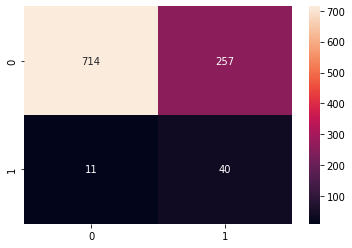

In [23]:
sns.heatmap(cf, annot = True, fmt='g')

We find that all three models have a hard time detecting the stroke patients while also keeping an overall high accuracy. 
I will try to optimize the hyperparameters of the Random Forest model to see if I can get a better performance. 

#### Tuning RF

We do a randomized search on hyperparameters. 
First we define a grid of parameters

In [24]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Random search and fit


In [25]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [26]:
# View best parameters from fitting
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

#### Evaluate Random search
Evaluate the random search based on recall of class 1 (stroke) only. 
Recall answers what proportion of actual positives aka strokes was identified correctly but in this case only among the stroke patients since this is the parameter that needs optimization. 

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       971
           1       0.14      0.82      0.24        51

    accuracy                           0.73      1022
   macro avg       0.56      0.78      0.54      1022
weighted avg       0.95      0.73      0.81      1022


Model Performance
Accuracy = 73.48%.
Recall strokes only = 82.35%.


<AxesSubplot:>

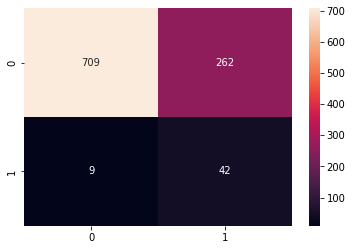

In [28]:
best_random = rf_random.best_estimator_
preds = best_random.predict(X_test)
print(classification_report(y_test,preds))
print()
cf = confusion_matrix(y_test,preds)
RF_performance = performance.evaluate(test_labels = y_test, predictions = preds)
sns.heatmap(cf, annot = True, fmt='g')

#### Grid search 

In [29]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': ['auto'], # sqrt of total number of featuers in data
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [1, 2, 4],
    'n_estimators': [500, 1000, 1500, 2000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [30]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 1500}

Evaluate the performance of the grid search

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       971
           1       0.14      0.82      0.24        51

    accuracy                           0.73      1022
   macro avg       0.56      0.78      0.54      1022
weighted avg       0.95      0.73      0.81      1022


Model Performance
Accuracy = 73.39%.
Recall strokes only = 82.35%.


<AxesSubplot:>

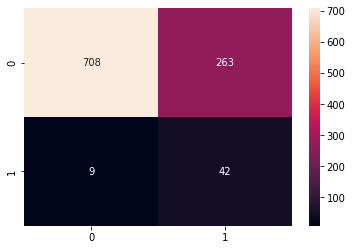

In [31]:
best_grid = grid_search.best_estimator_
preds = best_grid.predict(X_test)
print(classification_report(y_test,preds))
print()
cf = confusion_matrix(y_test,preds)
RF_performance = performance.evaluate(test_labels = y_test, predictions = preds)

sns.heatmap(cf, annot = True, fmt='g')

This model performs slightly better than the original random forest model in terms of predicting the stroke patients. This reduces the overall accuracy on the non-stroke patients through. 

We try and change threshold to make the model more sensitive to stroke cases   

              precision    recall  f1-score   support

           0       0.99      0.64      0.78       971
           1       0.12      0.88      0.20        51

    accuracy                           0.66      1022
   macro avg       0.55      0.76      0.49      1022
weighted avg       0.95      0.66      0.75      1022



<AxesSubplot:>

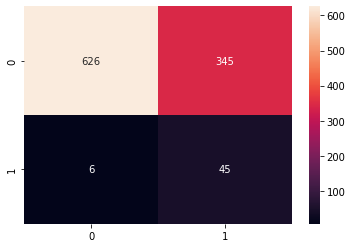

In [32]:
prediction_values = best_grid.predict_proba(X_test) 

threshold = 0.4
predicted = (prediction_values [:,1] >= threshold).astype('int')

print(classification_report(y_test, predicted))

cf__new_threshhold = confusion_matrix(y_test,predicted)
sns.heatmap(cf__new_threshhold, annot = True, fmt='g')


A couple more stroke patients gets correctly classified but around 100 more incorecctly classified non-stroke patients. 

# Save results
I choose to continue the analysis with the random forest model from the grid search.  
I have saved the best models from the three different methods. 
I also save the data from the second splitting that will also be used for the next part of the analysis. 

In [33]:
# Save model and data sets to use for interpretation
# save
#import joblib
#joblib.dump(best_grid, "./models/random_forest_best.joblib")
#joblib.dump(rf, "./models/random_forest_original.joblib")
#joblib.dump(rf_random, "./models/random_forest_RandomSearch.joblib")
#joblib.dump(XGB, "./models/XGB_model.joblib")
#joblib.dump(best_XGB_model, "./models/best_XGB.joblib")
#X_train.to_pickle("data/X_train.pkl")
#X_test.to_pickle("data/X_test.pkl")
#y_test.to_pickle("data/y_test.pkl")
#y_train.to_pickle("data/y_train.pkl")
#model.save('models/ANN_model.h5')